In [1]:
def reduce_mem_usage_colwise(col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = col.dtypes
    if col_type in numerics:
        c_min = col.min()
        c_max = col.max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col = col.astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col = col.astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col = col.astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col = col.astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                col = col.astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col = col.astype(np.float32)
            else:
                col = col.astype(np.float64)    
#     gc.collect()
    return col

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

from multiprocessing import Pool
from functools import partial
import gc
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%%time
DATA_PATH = 'Data/'
OUTPUT_PATH = 'Output/'

train = pd.read_csv(DATA_PATH + 'train_data.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_sub = pd.read_csv(DATA_PATH + 'Sample Submission.csv')

Wall time: 34.1 s


In [6]:
train = pd.merge(train, train_labels, on = 'patient_id', how='left')

In [7]:
cat_cols = ['event_name',  'plan_type', 'specialty']
num_cols = ['event_time', 'patient_payment']

train[cat_cols] = train[cat_cols].apply(lambda x: x.astype('category'))
test[cat_cols] = test[cat_cols].apply(lambda x: x.astype('category'))

ID_COL = 'patient_id'

In [8]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [9]:
%%time
df = pd.concat([train, test])
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])
df = df.sort_values(by=['patient_id', 'event_time'])
df = df.reset_index(drop=True)

Wall time: 9.48 s


In [10]:
cat_cols = ['event_name',  'plan_type', 'specialty']
num_cols = ['event_time', 'patient_payment']

In [11]:
del train, test
gc.collect()

0

In [12]:
event_name_patient_id_grpd = df.groupby(['event_name', 'patient_id']).agg({'event_time': ['min'], 'patient_payment': ['sum', 'max'], 'plan_type': ['nunique'], 'specialty': ['nunique']})
event_name_patient_id_grpd.columns = ['grpd_by_event_name_patient_id_' + '_'.join(c).strip('_') for c in event_name_patient_id_grpd.columns]
df = pd.merge(df, event_name_patient_id_grpd, on = ['event_name', 'patient_id'], how='left')

In [13]:
num_cols = num_cols + event_name_patient_id_grpd.columns.tolist()
del event_name_patient_id_grpd
gc.collect()

0

In [14]:
specialty_patient_id_grpd = df.groupby(['specialty', 'patient_id']).agg({'event_time': ['min','max'], 'patient_payment': ['sum', 'max'], 'plan_type': ['nunique'], 'event_name': ['nunique']})
specialty_patient_id_grpd.columns = ['grpd_by_specialty_patient_id_' + '_'.join(c).strip('_') for c in specialty_patient_id_grpd.columns]
df = pd.merge(df, specialty_patient_id_grpd, on = ['specialty', 'patient_id'], how='left')

In [15]:
num_cols = num_cols + specialty_patient_id_grpd.columns.tolist()
del specialty_patient_id_grpd
gc.collect()

0

In [16]:
plan_type_patient_id_grpd = df.groupby(['plan_type', 'patient_id']).agg({'event_time': ['min','max'], 'patient_payment': ['sum', 'max'], 'specialty': ['nunique'], 'event_name': ['nunique']})
plan_type_patient_id_grpd.columns = ['grpd_by_plan_type_patient_id_' + '_'.join(c).strip('_') for c in plan_type_patient_id_grpd.columns]
df = pd.merge(df, plan_type_patient_id_grpd, on = ['plan_type', 'patient_id'], how='left')

In [17]:
num_cols = num_cols + plan_type_patient_id_grpd.columns.tolist()
del plan_type_patient_id_grpd
gc.collect()

0

In [18]:
event_time_patient_id_grpd = df.groupby(['event_time', 'patient_id']).agg({'plan_type': ['nunique'], 'patient_payment': ['sum', 'max'], 'specialty': ['nunique'], 'event_name': ['nunique']})
event_time_patient_id_grpd.columns = ['grpd_by_event_time_patient_id_' + '_'.join(c).strip('_') for c in event_time_patient_id_grpd.columns]
df = pd.merge(df, event_time_patient_id_grpd, on = ['event_time', 'patient_id'], how='left')

In [19]:
num_cols = num_cols + event_time_patient_id_grpd.columns.tolist()
del event_time_patient_id_grpd
gc.collect()

0

In [20]:
features = [c for c in df.columns if c not in ['patient_id', 'plan_type']]

In [21]:
event_name_grpd = df.groupby('event_name').agg({'event_time': ['min'], 'patient_id': ['nunique'], 'patient_payment': ['sum', 'max'], 'plan_type': ['nunique'], 'specialty': ['nunique']})
event_name_grpd.columns = ['grpd_by_event_name_' + '_'.join(c).strip('_') for c in event_name_grpd.columns]
df = pd.merge(df, event_name_grpd, on = 'event_name', how='left')

num_cols = num_cols + event_name_grpd.columns.tolist()
del event_name_grpd
features = [c for c in df.columns if c not in ['patient_id']]
df[features] = df[features].apply(lambda x: reduce_mem_usage_colwise(x))
gc.collect()

0

In [22]:
specialty_grpd = df.groupby('specialty').agg({'event_time': ['min'], 'patient_id': ['nunique'], 'patient_payment': ['sum', 'max'], 'plan_type': ['nunique'], 'event_name': ['nunique', 'size']})
specialty_grpd.columns = ['grpd_by_specialty_' + '_'.join(c).strip('_') for c in specialty_grpd.columns]
df = pd.merge(df, specialty_grpd, on = 'specialty', how='left')

num_cols = num_cols + specialty_grpd.columns.tolist()
features = [c for c in df.columns if c not in ['patient_id']]
df[features] = df[features].apply(lambda x: reduce_mem_usage_colwise(x))
del specialty_grpd
gc.collect()

0

In [23]:
plan_type_grpd = df.groupby('plan_type').agg({'event_time': ['min'], 'patient_id': ['nunique'], 'patient_payment': ['sum', 'max'], 'specialty': ['nunique'],
                                              'event_name': ['nunique']})
plan_type_grpd.columns = ['grpd_by_plan_type_' + '_'.join(c).strip('_') for c in plan_type_grpd.columns]
df = pd.merge(df, plan_type_grpd, on = 'plan_type', how='left')

num_cols = num_cols + plan_type_grpd.columns.tolist()
features = [c for c in df.columns if c not in ['patient_id']]
df[features] = df[features].apply(lambda x: reduce_mem_usage_colwise(x))
del plan_type_grpd
gc.collect()

0

In [24]:
event_time_grpd = df.groupby('event_time').agg({'plan_type': ['nunique'], 'patient_id': ['nunique'], 'patient_payment': ['sum', 'max'], 'specialty': ['nunique'], 'event_time': ['min'],
                                               'event_name': ['nunique']})
event_time_grpd.columns = ['grpd_by_event_time_' + '_'.join(c).strip('_') for c in event_time_grpd.columns]
df = pd.merge(df, event_time_grpd, on = 'event_time', how='left')

num_cols = num_cols + event_time_grpd.columns.tolist()
features = [c for c in df.columns if c not in ['patient_id']]
df[features] = df[features].apply(lambda x: reduce_mem_usage_colwise(x))
del event_time_grpd
gc.collect()

0

In [25]:
df.shape
gc.collect()

0

In [26]:
features = [c for c in df.columns if c not in ['patient_id']]
df[features] = df[features].apply(lambda x: reduce_mem_usage_colwise(x))

In [27]:
add_num_cols = []
grp_name = 'patient_id'
grp = df.groupby('patient_id')

num_cumsum_cols = [c + grp_name + '_cumsum' for c in num_cols]
add_num_cols = add_num_cols + num_cumsum_cols
total_num_cols = len(num_cumsum_cols)

#Broken into two parts to keep RAM USAGE low
df[num_cumsum_cols[0:len(num_cumsum_cols)//2]] = df[num_cols[0:len(num_cols)//2]].apply(lambda x: reduce_mem_usage_colwise(grp[x.name].cumsum()))
print("DONE")
gc.collect()
df[num_cumsum_cols[len(num_cumsum_cols)//2:]] = df[num_cols[len(num_cols)//2:]].apply(lambda x: reduce_mem_usage_colwise(grp[x.name].cumsum()))
print("DONE")
gc.collect()

num_cols = list(set(num_cols + add_num_cols))

DONE
DONE


In [28]:
add_freq_cols = cat_cols
freq_cols = [c + '_freq' for c in add_freq_cols]
df[freq_cols] = df[add_freq_cols].apply(lambda x: reduce_mem_usage_colwise(x.map(x.value_counts())))

add_freq_cumsum = [c + grp_name + '_cumsum' for c in freq_cols]
df[add_freq_cumsum] = df[freq_cols].apply(lambda x: reduce_mem_usage_colwise(grp[x.name].cumsum()))
num_cols = num_cols + freq_cols + add_freq_cumsum

df['patient_id_freq'] = df['patient_id'].map(df['patient_id'].value_counts())
num_cols = num_cols + ['patient_id_freq']

In [ ]:
%%time
aggs = {}
for c in cat_cols:
    aggs[c] = ['nunique']
for c in num_cols:
    aggs[c] = ['sum', 'min', 'max', 'std']
    
def apply_aggs(col):
    res_lists = []
    all_aggs = aggs[col]
    for agg_func in all_aggs:
        ser = pd.Series(grp[col].agg(agg_func), name = col + '_' + agg_func)
        res_lists.append(ser)
    return res_lists

grp = df.groupby('patient_id')
try:
    pool = Pool(4) 
    all_aggs = pool.map(apply_aggs, (col for col in aggs.keys()))
finally: 
    pool.close()
    pool.join()

In [ ]:
all_aggs_flattened = [x for nested_list in all_aggs for x in nested_list]
print(len(all_aggs_flattened))
comp_df = pd.DataFrame(all_aggs_flattened).T
comp_df = comp_df.reset_index()

In [ ]:
del all_aggs, all_aggs_flattened
gc.collect()

In [ ]:
comp_df.shape

In [ ]:
ID_COL, TARGET_COL = 'patient_id', 'outcome_flag'

In [ ]:
grp = df.groupby('patient_id')
comp_df = pd.merge(comp_df, grp['patient_payment'].agg(lambda x: x.values[-1]).rename('patient_payment_last_value').reset_index(), on = 'patient_id', how ='left')
comp_df = pd.merge(comp_df, grp['event_time'].agg(lambda x: x.values[-1]).rename('event_time_last_value').reset_index(), on = 'patient_id', how ='left')

In [ ]:
features = [c for c in comp_df if c not in [ID_COL, TARGET_COL]]

In [ ]:
comp_df[features] = comp_df[features].apply(lambda x: reduce_mem_usage_colwise(x))

In [ ]:
comp_train = pd.merge(train_labels, comp_df, how = 'inner', on = 'patient_id')
comp_test = pd.merge(sample_sub, comp_df, how = 'inner', on = 'patient_id')
target = comp_train[TARGET_COL]
comp_train.shape, train_labels.shape, comp_test.shape, sample_sub.shape

In [ ]:
del comp_df
gc.collect()

In [37]:
param = {'num_leaves': 5000,
         'min_data_in_leaf': 400, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.55,
         "metric": 'auc',
         "lambda_l1": 6,
         "lambda_l2": 2,
         "random_state": 6,
         "verbosity": -1,
         'two_round': True,
         'cat_smooth': 1,
          'cat_l2':1,
         'two_round': True}
gc.collect()

0

In [38]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter, random_state=1991)
oof = np.zeros(len(comp_train))
categorical_columns = None
predictions_test = np.zeros(len(comp_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(comp_train.values, target)):
    print("fold n°{}".format(fold_))
    X_trn, y_trn = comp_train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = comp_train.iloc[val_idx][features], target.iloc[val_idx]
    X_comp_test = comp_test[features]
    trn_data = lgb.Dataset(X_trn, y_trn, categorical_feature = categorical_columns)
    val_data = lgb.Dataset(X_val, y_val, categorical_feature = categorical_columns)
    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
    
    del trn_data, val_data, X_trn, X_val, y_trn, y_val
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    current_comp_test_pred = clf.predict(X_comp_test, num_iteration=clf.best_iteration)
    predictions_test += current_comp_test_pred / folds.n_splits
    
    del X_comp_test, current_comp_test_pred, clf
    
    gc.collect()

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0
Training until validation scores don't improve for 400 rounds
[200]	training's auc: 0.80984	valid_1's auc: 0.731885
[400]	training's auc: 0.848279	valid_1's auc: 0.744236
[600]	training's auc: 0.879354	valid_1's auc: 0.749324
[800]	training's auc: 0.904028	valid_1's auc: 0.752293
[1000]	training's auc: 0.924389	valid_1's auc: 0.752224
[1200]	training's auc: 0.940718	valid_1's auc: 0.752241
Early stopping, best iteration is:
[851]	training's auc: 0.909565	valid_1's auc: 0.753483
fold n°1
Training until validation scores don't improve for 400 rounds
[200]	training's auc: 0.808651	valid_1's auc: 0.748934
[400]	training's auc: 0.847154	valid_1's auc: 0.756088
[600]	training's auc: 0.8784	valid_1's auc: 0.757948
[800]	training's auc: 0.903163	valid_1's auc: 0.758198
[1000]	training's auc: 0.923383	valid_1's auc: 0.757573
Early stopping, best iteration is:
[669]	training's auc: 0.887528	valid_1's auc: 0.758926
fold n°2
Training until validation scores don't improve for 400 rounds
[2

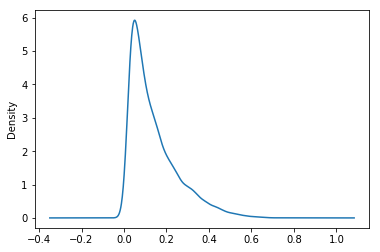

In [39]:
pd.Series(predictions_test).plot(kind='density')

In [40]:
oof_df = pd.DataFrame()
oof_df['patient_id'] = comp_train['patient_id']
oof_df[TARGET_COL] = oof
oof_df.to_csv(OUTPUT_PATH + 'oofs_lgbm.csv', index=False)

In [41]:
sub_df = pd.DataFrame()
sub_df[ID_COL] = comp_test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df[[TARGET_COL]].to_excel(OUTPUT_PATH +'preds_lgbm.xlsx', index=False)
sub_df.head(10)

,patient_id,outcome_flag
0,patient_2,0.226579
1,patient_3,0.161460
2,patient_5,0.445144
3,patient_8,0.027795
4,patient_14,0.139229
5,patient_15,0.090780
6,patient_16,0.079721
7,patient_33,0.140987
8,patient_38,0.060210
9,patient_41,0.568861
